In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
%matplotlib inline
from tqdm import notebook
import tensorflow as tf
from scipy import stats
from scipy.interpolate import interp1d

### simulate data

In [2]:
np.random.seed(2020)

# generate mu, gaussian
mu=np.random.normal(scale=2,size=1000)

# generate sd, uniform
sig=np.random.uniform(0.5,2.5,size=1000)


# the full design matrix
x=np.c_[mu,sig]


y=np.random.normal(loc=mu,scale=sig,size=(1000,1))


train_x=x[:700,:]
train_y=y[:700,:]

test_x=x[700:,:]
test_y=y[700:,:]

ntrain=len(train_x)
ntest=len(test_x)


In [3]:
train_x.shape

(700, 2)

In [4]:
stats.describe(y)

DescribeResult(nobs=1000, minmax=(array([-7.80706614]), array([9.29692822])), mean=array([-0.05449282]), variance=array([5.94032471]), skewness=array([0.16419596]), kurtosis=array([0.14757842]))

### g-only, this is equivalent to using pre-training in under the Collaborating Network(CN) framework

In [5]:
def variables_from_scope(scope_name):
    """
    Returns a list of all trainable variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope_name)

In [6]:
 # Graph parameters
intermediate_layer_size = 100
intermediate_layer_size2 = 80
# Training parameters
batch_size = 100
pre_iter= ntrain*100

In [7]:
# g function learn the cdf
def g(yq,x):
    """
    yq:quantile:,
    x:input feature and treatment,
    """
    z1=tf.concat([yq,x],axis=1)
    hidden_layer = tf.compat.v1.layers.dense(z1, intermediate_layer_size,kernel_initializer=tf.compat.v1.initializers.random_normal(stddev=.001), name="g1", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer_bn = tf.compat.v1.layers.batch_normalization(hidden_layer,name="g1bn")
    hidden_layer2 = tf.compat.v1.layers.dense(hidden_layer_bn, intermediate_layer_size2, kernel_initializer=tf.compat.v1.initializers.random_normal(stddev=.001),name="g2", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer2_bn = tf.compat.v1.layers.batch_normalization(hidden_layer2,name="g2bn")
    gq_logit = tf.compat.v1.layers.dense(hidden_layer2_bn, 1,kernel_initializer=tf.initializers.glorot_normal, name="g3", activation=None,reuse=None)
    gq_logit_bn=tf.keras.layers.BatchNormalization(axis=-1,momentum=.1)(gq_logit)
    return gq_logit_bn

In [8]:
tf.compat.v1.disable_eager_execution()

In [9]:

tf.compat.v1.reset_default_graph()

# Placeholders
y_ = tf.compat.v1.placeholder(tf.float32, [None, 1])

pre_y= tf.compat.v1.placeholder(tf.float32, [None, 1])
x_=tf.compat.v1.placeholder(tf.float32, [None, x.shape[1]])
q_ = tf.compat.v1.placeholder(tf.float32, [None, 1])


ylessthan_pre= tf.cast(tf.less_equal(y_,pre_y),tf.float32)


with tf.compat.v1.variable_scope("g") as scope:
    gq_logit_pre = g(pre_y,x_)
    gq=tf.sigmoid(gq_logit_pre)*.99999+.00001




#pre-loss
g_loss_pre = tf.compat.v1.losses.sigmoid_cross_entropy(ylessthan_pre,gq_logit_pre)

# Optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)
pre_step= optimizer.minimize(g_loss_pre,var_list=variables_from_scope("g"))


# Initializer
initialize_all = tf.compat.v1.global_variables_initializer()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


### Training

In [10]:
sess = tf.compat.v1.Session()
sess.run(initialize_all)
glpre=[]


for k in notebook.tnrange(pre_iter):
    i=np.random.randint(0,ntrain,batch_size)
    ytmp = train_y[i,:]
    xtmp= train_x[i,:]
    #when we do not have f initially, we use a uniform distribution to extract points from support
    pre_ytmp=np.random.uniform(-11,11,(batch_size,1))  
    ltmp,_=sess.run([g_loss_pre,pre_step],feed_dict={y_: ytmp,
                                x_:xtmp,
                                pre_y:pre_ytmp})
    
    glpre.append(ltmp)

    

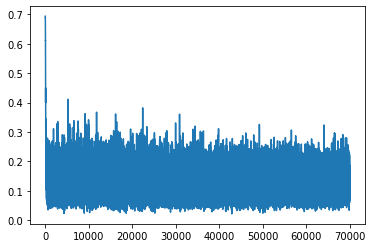

In [ ]:
plt.plot(glpre)

### log likelihood_truth

In [ ]:
low=np.quantile(test_y,0.05)
high=np.quantile(test_y,0.95)
itv=np.linspace(low,high,9)
itv=np.append(-np.infty,itv)
itv=np.append(itv,np.infty)
#outcome1 belongs to which interval
id=np.zeros(ntest)
for i in range(10):
    id=id+1*(test_y.ravel()>itv[i+1])
id=id.astype('int')


In [ ]:
#calculate the likelihood for ground truth
loglikgth=np.empty([ntest])
for i in range(ntest):
    l=itv[id[i]]
    r=itv[id[i]+1]
    loglikgth[i]=np.log(stats.norm.cdf((r-test_x[i,0])/test_x[i,1])-stats.norm.cdf((l-test_x[i,0])/test_x[i,1])+1.e-10)

In [ ]:
loglikgth.mean()

-1.6464826504318846

### calibration_truth

In [ ]:
per=np.linspace(0.02,0.98,8)

In [ ]:
calgt=np.empty([len(per)])
diff=np.abs(test_y-test_x[:,0].reshape(-1,1)).ravel()/(test_x[:,1].ravel())
for i in range(len(per)):
    q=stats.norm.ppf(0.5+per[i]/2)
    calgt[i]=np.mean(diff<q)


In [ ]:
np.abs(calgt-per).mean()

0.01785714285714283

In [ ]:
np.mean(diff<stats.norm.ppf(0.95))

0.9

In [ ]:
np.abs(test_y-test_x[:,0].reshape(-1,1)).ravel().mean()

1.1330942071727474

### estimate calibration and likelihood

In [ ]:
# estimation by g
med_est=np.array([])
ll_est=np.empty(ntest)
cal_est=np.zeros_like(per)



#use interpolation to recover cdf
xtmp=np.linspace(-10,10,5000)


for i in notebook.trange(ntest):

    #cdf estimate by g
    cdf=sess.run(gq ,feed_dict={x_:np.tile(test_x[i,:],(5000,1)),
                                pre_y:xtmp[:,None]
                                }).ravel()

    invcdfest=interp1d(cdf,xtmp)
    cdfest=interp1d(xtmp,cdf)

    
      
    #estimate the ite
    med_est=np.append(med_est,invcdfest(0.5))    
    #estimate the loglikelihood
    l=itv[id[i]]
    r=itv[id[i]+1]


    if(r==np.inf):
        ll_est[i]=np.log(1.-cdfest(l)+1.e-10)
    elif(l==-np.inf):
        ll_est[i]=np.log(cdfest(r)+1.e-10)
    else:
        ll_est[i]=np.log(cdfest(r)-cdfest(l)+1.e-10)

    
    #estimate the calibration
    cal_est=cal_est+1.*(test_y[i]<invcdfest(0.5+per/2))*(test_y[i]>invcdfest(0.5-per/2))

cal_est=cal_est/ntest

In [ ]:
cal_est

array([0.02666667, 0.16333333, 0.29      , 0.45666667, 0.61333333,
       0.76      , 0.85666667, 0.98666667])

In [ ]:
np.abs(cal_est-per).mean()

0.020238095238095215

In [ ]:
ll_est.mean()

-1.66121559047082

In [ ]:
np.abs(test_y.ravel()-med_est).mean()

1.1334576382141812

#### calculate 90% interval width and coverage

In [11]:
width_est=np.empty(ntest)
cover_90=0

fwidth_est=np.empty(ntest)
fcover_90=0

#use interpolation to recover cdf
xtmp=np.linspace(-10,10,5000)
ptmp=np.linspace(0.001,0.999,5000)

for i in notebook.trange(ntest):
    #cdf estimate
    cdf=sess.run(gq ,feed_dict={x_:np.tile(test_x[i,:],(5000,1)),
                                pre_y:xtmp[:,None]
                                }).ravel()
    
     

    invcdfest=interp1d(cdf,xtmp)
    r=invcdfest(0.95)
    l=invcdfest(0.05)
    cover_90+=(test_y[i]<r)*(test_y[i]>l)
    width_est[i]=invcdfest(0.95)-invcdfest(0.05)




print(cover_90/ntest)


[0.9]


In [13]:
np.save('gwidth',width_est)

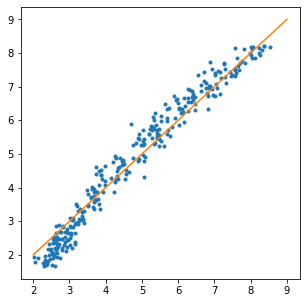

In [12]:
plt.figure(figsize=(5,5))
plt.plot(width_est,test_x[:,1].ravel()*2.*1.64,'.')

plt.plot([2,9],[2,9])

### Compare the generated distribution to groud truth for three random samples

In [ ]:
#generate sample
np.random.seed(2020)
samps=np.random.choice(len(test_x),3)

In [ ]:
samps

array([118, 195,  91])

In [ ]:
#the mean and sd for the random sample
musd=test_x[samps]

In [ ]:
musd

array([[ 1.67091651,  1.66674477],
       [-1.34299445,  1.77077775],
       [-1.40733603,  2.09394208]])

In [ ]:
yrange=np.linspace(musd[:,0]-4*musd[:,1],musd[:,0]+4*musd[:,1],5000)

In [ ]:
#estimate cdf by g
est_cdf=sess.run(gq ,feed_dict={x_:np.repeat(musd,5000,axis=0),
                                pre_y:yrange.T.ravel().reshape(-1,1),
                                })
est_cdf=est_cdf.reshape(3,-1).T

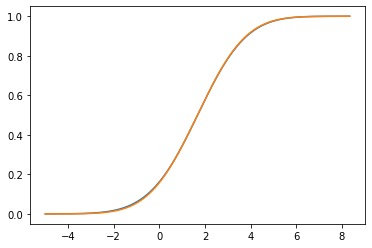

In [ ]:
tcdf=stats.norm.cdf((yrange[:,0]-musd[0,0])/musd[0,1])
plt.plot(yrange[:,0],est_cdf[:,0])
plt.plot(yrange[:,0],tcdf)

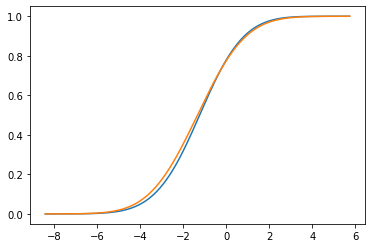

In [ ]:
tcdf=stats.norm.cdf((yrange[:,1]-musd[1,0])/musd[1,1])
plt.plot(yrange[:,1],est_cdf[:,1])
plt.plot(yrange[:,1],tcdf)


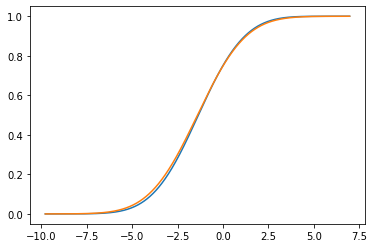

In [ ]:
tcdf=stats.norm.cdf((yrange[:,2]-musd[2,0])/musd[2,1])
plt.plot(yrange[:,2],est_cdf[:,2])
plt.plot(yrange[:,2],tcdf)

In [ ]:
np.save('est_cdf_g',est_cdf)
